## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
class RectifiedAdam(tf.keras.optimizers.Optimizer):
    """Variant of the Adam optimizer whose adaptive learning rate is rectified
    so as to have a consistent variance.
    It implements the Rectified Adam (a.k.a. RAdam) proposed by
    Liyuan Liu et al. in [On The Variance Of The Adaptive Learning Rate
    And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf).
    Example of usage:
    ```python
    opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
    ```
    Note: `amsgrad` is not described in the original paper. Use it with
          caution.
    RAdam is not a placement of the heuristic warmup, the settings should be
    kept if warmup has already been employed and tuned in the baseline method.
    You can enable warmup by setting `total_steps` and `warmup_proportion`:
    ```python
    opt = tfa.optimizers.RectifiedAdam(
        lr=1e-3,
        total_steps=10000,
        warmup_proportion=0.1,
        min_lr=1e-5,
    )
    ```
    In the above example, the learning rate will increase linearly
    from 0 to `lr` in 1000 steps, then decrease linearly from `lr` to `min_lr`
    in 9000 steps.
    Lookahead, proposed by Michael R. Zhang et.al in the paper
    [Lookahead Optimizer: k steps forward, 1 step back]
    (https://arxiv.org/abs/1907.08610v1), can be integrated with RAdam,
    which is announced by Less Wright and the new combined optimizer can also
    be called "Ranger". The mechanism can be enabled by using the lookahead
    wrapper. For example:
    ```python
    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    ```
    """

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 weight_decay=0.,
                 amsgrad=False,
                 sma_threshold=5.0,
                 total_steps=0,
                 warmup_proportion=0.1,
                 min_lr=0.,
                 name='RectifiedAdam',
                 **kwargs):
        r"""Construct a new RAdam optimizer.
        Args:
            learning_rate: A `Tensor` or a floating point value. or a schedule
                that is a `tf.keras.optimizers.schedules.LearningRateSchedule`
                The learning rate.
            beta_1: A float value or a constant float tensor.
                The exponential decay rate for the 1st moment estimates.
            beta_2: A float value or a constant float tensor.
                The exponential decay rate for the 2nd moment estimates.
            epsilon: A small constant for numerical stability.
            weight_decay: A floating point value. Weight decay for each param.
            amsgrad: boolean. Whether to apply AMSGrad variant of this
                algorithm from the paper "On the Convergence of Adam and
                beyond".
            sma_threshold. A float value.
                The threshold for simple mean average.
            total_steps: An integer. Total number of training steps.
                Enable warmup by setting a positive value.
            warmup_proportion: A floating point value.
                The proportion of increasing steps.
            min_lr: A floating point value. Minimum learning rate after warmup.
            name: Optional name for the operations created when applying
                gradients. Defaults to "RectifiedAdam".
            **kwargs: keyword arguments. Allowed to be {`clipnorm`,
                `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients
                by norm; `clipvalue` is clip gradients by value, `decay` is
                included for backward compatibility to allow time inverse
                decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """
        super(RectifiedAdam, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('weight_decay', weight_decay)
        self._set_hyper('sma_threshold', sma_threshold)
        self._set_hyper('total_steps', float(total_steps))
        self._set_hyper('warmup_proportion', warmup_proportion)
        self._set_hyper('min_lr', min_lr)
        self.epsilon = epsilon or tf.keras.backend.epsilon()
        self.amsgrad = amsgrad
        self._initial_weight_decay = weight_decay
        self._initial_total_steps = total_steps

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        if self.amsgrad:
            for var in var_list:
                self.add_slot(var, 'vhat')

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(RectifiedAdam, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps *\
                self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = tf.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * tf.minimum(local_step - warmup_steps,
                                               decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (
            1.0 - beta_2_power)

        m_t = m.assign(
            beta_1_t * m + (1.0 - beta_1_t) * grad,
            use_locking=self._use_locking)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v_t = v.assign(
            beta_2_t * v + (1.0 - beta_2_t) * tf.square(grad),
            use_locking=self._use_locking)
        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = vhat.assign(
                tf.maximum(vhat, v_t), use_locking=self._use_locking)
            v_corr_t = tf.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = tf.sqrt(v_t / (1.0 - beta_2_power))

        r_t = tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) /
                      (sma_inf - 2.0) * sma_inf / sma_t)

        sma_threshold = self._get_hyper('sma_threshold', var_dtype)
        var_t = tf.where(sma_t >= sma_threshold,
                         r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = var.assign_sub(
            lr_t * var_t, use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return tf.group(*updates)

    def _resource_apply_sparse(self, grad, var, indices):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps *\
                self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = tf.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * tf.minimum(local_step - warmup_steps,
                                               decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (
            1.0 - beta_2_power)

        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * (1 - beta_1_t)
        m_t = m.assign(m * beta_1_t, use_locking=self._use_locking)
        with tf.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * (1 - beta_2_t)
        v_t = v.assign(v * beta_2_t, use_locking=self._use_locking)
        with tf.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = vhat.assign(
                tf.maximum(vhat, v_t), use_locking=self._use_locking)
            v_corr_t = tf.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = tf.sqrt(v_t / (1.0 - beta_2_power))

        r_t = tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) /
                      (sma_inf - 2.0) * sma_inf / sma_t)

        sma_threshold = self._get_hyper('sma_threshold', var_dtype)
        var_t = tf.where(sma_t >= sma_threshold,
                         r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        with tf.control_dependencies([var_t]):
            var_update = self._resource_scatter_add(
                var, indices, tf.gather(-lr_t * var_t, indices))

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return tf.group(*updates)

    def get_config(self):
        config = super(RectifiedAdam, self).get_config()
        config.update({
            'learning_rate':
            self._serialize_hyperparameter('learning_rate'),
            'beta_1':
            self._serialize_hyperparameter('beta_1'),
            'beta_2':
            self._serialize_hyperparameter('beta_2'),
            'decay':
            self._serialize_hyperparameter('decay'),
            'weight_decay':
            self._serialize_hyperparameter('weight_decay'),
            'sma_threshold':
            self._serialize_hyperparameter('sma_threshold'),
            'epsilon':
            self.epsilon,
            'amsgrad':
            self.amsgrad,
            'total_steps':
            self._serialize_hyperparameter('total_steps'),
            'warmup_proportion':
            self._serialize_hyperparameter('warmup_proportion'),
            'min_lr':
            self._serialize_hyperparameter('min_lr'),
        })
        return config

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-tail/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-tail/fold_1.tar.gz

Train samples: 400830


,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,And you have something alien on your lips Chan...,0.000000,0,train,train,validation,train,train
1,no income tax for anyone that comes and works ...,0.166667,0,train,train,train,train,validation
2,"Rubbish, Brandon. Nothing stopped Comey of the...",0.833333,1,train,train,validation,train,train
3,poster I have sent the e-mail. -Garrett,0.000000,0,train,train,validation,train,train
4,== ECB exposure == I responded to a comment of...,0.000000,0,train,train,validation,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


fold_1/
fold_1/x_train_tail.npy
fold_1/x_train.npy
fold_1/x_valid_tail.npy
fold_1/y_train_int.npy
fold_1/x_valid.npy
fold_1/y_train.npy
fold_1/y_valid.npy
fold_1/y_valid_int.npy


# Model parameters

In [5]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 6,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Learning rate schedule

In [6]:
step_size = len( k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']
warmup_steps = step_size * 1 
total_steps = config['EPOCHS'] * step_size

# rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
# y = [constant_schedule_with_warmup(x, warmup_steps=warmup_steps, lr_start=1e-7, 
#                                    lr_max=config['LEARNING_RATE']) for x in rng]

# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_avg = layers.GlobalAveragePooling1D()(last_hidden_state)
    x_max = layers.GlobalMaxPooling1D()(last_hidden_state)
    x = layers.Concatenate()([x_avg, x_max])
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [8]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').reshape(x_train.shape[1], 1).astype(np.float32)
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)
    
    #################### ADD TAIL ####################
    x_train = np.hstack([x_train, np.load(base_data_path + 'x_train_tail.npy')])
    y_train = np.vstack([y_train, y_train])
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)
    
    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_accuracy.update_state(y, probabilities)
            train_auc.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            valid_accuracy.update_state(y, probabilities)
            valid_auc.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        optimizer = RectifiedAdam(lr=config['LEARNING_RATE'], total_steps=total_steps, 
                                  warmup_proportion=0.1, min_lr=1e-7)
        loss_fn = losses.binary_crossentropy

        train_accuracy = metrics.BinaryAccuracy()
        valid_accuracy = metrics.BinaryAccuracy()
        train_auc = metrics.AUC()
        valid_auc = metrics.AUC()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'auc': train_auc, 'accuracy': train_accuracy, 
                    'val_loss': valid_loss, 'val_auc': valid_auc, 'val_accuracy': valid_accuracy}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], model_path)
    
    history_list.append(history)
    model.load_weights(model_path)
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
    valid_ml_preds = model.predict(get_test_dataset(x_valid_ml, config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
    valid_df['pred_%d' % (n_fold+1)] = valid_ml_preds


FOLD: 1
Train for 5010 steps, validate for 62 steps

EPOCH 1/6
time: 1743.0s loss: 0.3848 auc: 0.9044 accuracy: 0.5532 val_loss: 0.2829 val_auc: 0.9289 val_accuracy: 0.8807
Saved model weights at "model_fold_1.h5"

EPOCH 2/6
time: 1483.8s loss: 0.3187 auc: 0.9466 accuracy: 0.5746 val_loss: 0.2497 val_auc: 0.9227 val_accuracy: 0.8804
Saved model weights at "model_fold_1.h5"

EPOCH 3/6
time: 1486.8s loss: 0.3034 auc: 0.9552 accuracy: 0.5793 val_loss: 0.2441 val_auc: 0.9188 val_accuracy: 0.8833
Saved model weights at "model_fold_1.h5"

EPOCH 4/6
time: 1495.8s loss: 0.2978 auc: 0.9585 accuracy: 0.5809 val_loss: 0.2537 val_auc: 0.9144 val_accuracy: 0.8787
Epoch 00004: early stopping


## Model loss graph

Fold: 1


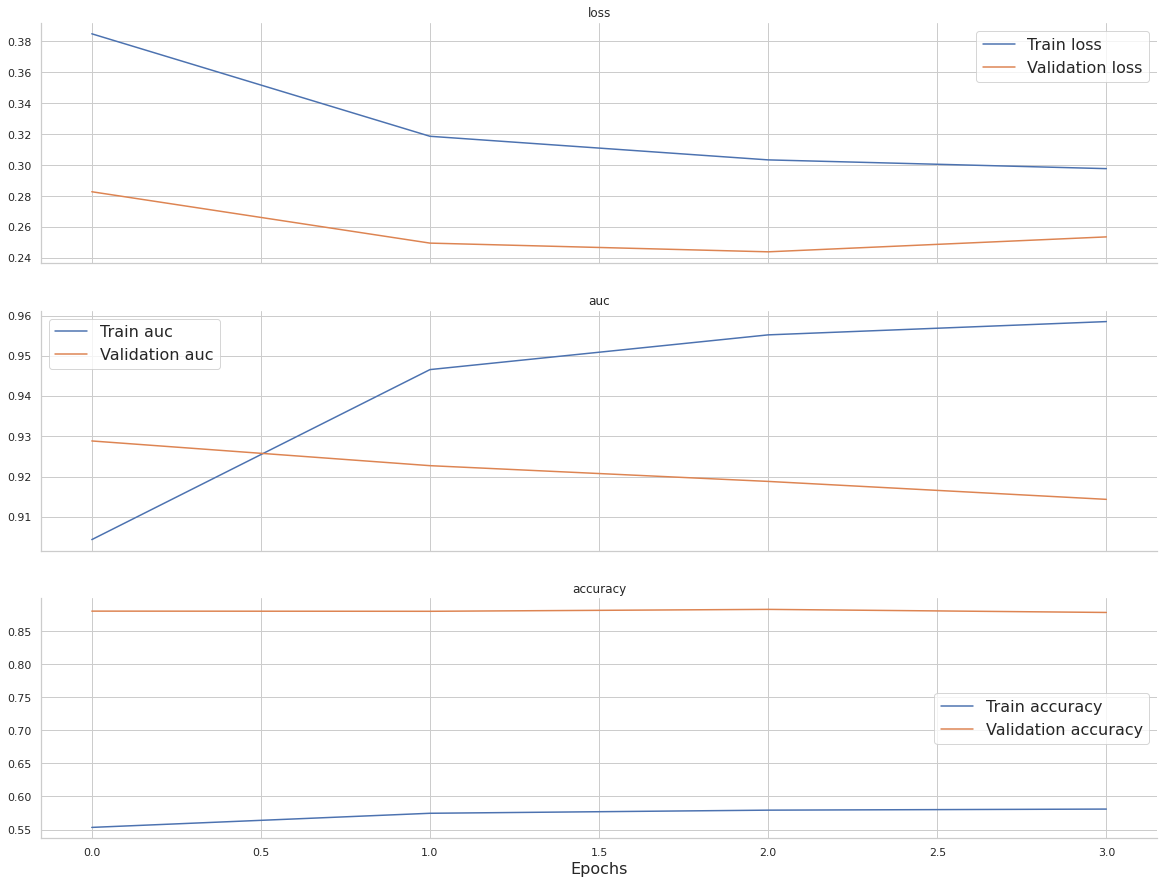

In [9]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [10]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [11]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [12]:
display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.918615,0.918615
es,0.891855,0.891855
it,0.887199,0.887199
tr,0.978766,0.978766


# Visualize predictions

In [13]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,And you have something alien on your lips Chance. Geez dude give it up. Better yet why don't you ask the Krotch brot...,0.000000
1,no income tax for anyone that comes and works and leaves. no income tax for retirees that come and work and leave. n...,0.166667
2,"Rubbish, Brandon. Nothing stopped Comey of the FBI of dumping the phony story about a new investigation in Hillary's...",0.833333
3,poster I have sent the e-mail. -Garrett,0.000000
4,== ECB exposure == I responded to a comment of yours here. Cheers.,0.000000
5,"You said, Let's keep abortion safe. Did you mean safe for the mom, or safe for the baby? God forgives women (and men...",0.200000
6,I was responding to Gary (and others) and the letter writer. I believe Christians would be slow to act in this situa...,0.000000
7,Now you disagree with your own comment?,0.000000
8,Amarista definitely needs to go away. If for no other reason than the best poster on this site Northsider will see h...,0.000000
9,"Corspefucking Art I used their offical website as help to gte al information right. Therefore, some sentences were l...",1.000000


Multilingual validation set


,comment_text,toxic,pred_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.531601
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.001644
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.517299
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.011670
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.007833
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.018782
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.016767
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.002364
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.017669
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.052681


# Test set predictions

In [14]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [15]:
x_test = np.load(database_base_path + 'x_test.npy')
NUM_TEST_IMAGES = x_test.shape[1]
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [16]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,6.381200e+04
mean,31905.500000,1.811615e-01
std,18421.082026,2.401615e-01
min,0.000000,2.980232e-08
25%,15952.750000,4.260808e-03
50%,31905.500000,4.680605e-02
75%,47858.250000,3.116599e-01
max,63811.000000,9.999754e-01


,id,toxic
0,0,0.000072
1,1,0.000539
2,2,0.317731
3,3,0.005029
4,4,0.000900
5,5,0.092304
6,6,0.000017
7,7,0.031712
8,8,0.469231
9,9,0.194081
